# 개선된 U-Net 모델 만들기
## 세그멘테이션 모델 만들기

## -목차
1. 데이터셋 수집 및 구축
2. 세그멘테이션 모델 구축    
    2.1 U-Net 모델 구현   
    2.2 U-Net++ 모델 구현   
3. 세그멘테이션 모델 결과 비교


- 프로젝트 정리

## 1. 데이터셋 수집 및 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
#Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용 예시

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    #훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    #50%의 확률로 좌우대칭
                    RandomSizedCrop(         #50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              #입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      #테스트용 데이터일 경우에는 224X224로 resize만 수행. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

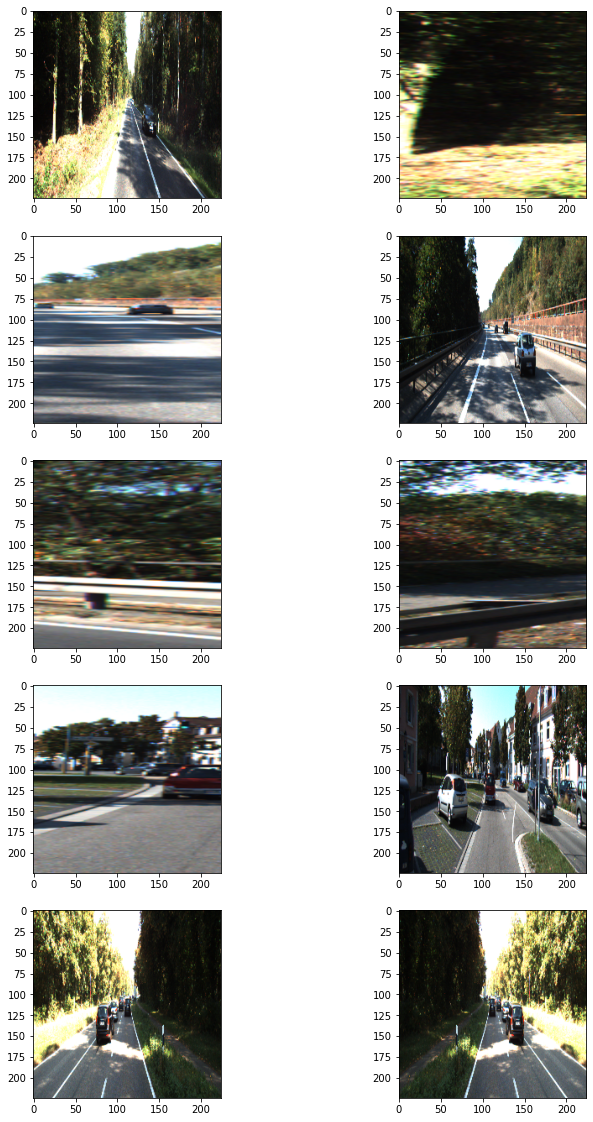

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))
  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  #왼쪽=원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽=augment된 이미지

In [4]:
#데이터셋 구성
#tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받음.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path.
    batch_size: batch_size.
    img_size: preprocess에 사용할 입력이미지의 크기.
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: 이 Generator가 학습용인지 테스트용인지 구분.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받음.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    #load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인.
    self.data = self.load_dataset()

  def load_dataset(self):
    #kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수.
    #is_train에 따라 test set을 분리해서 load.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
        return data[:-30]
    return data[-30:]
    
  def __len__(self):
    #Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    #입력은 resize및 augmentation이 적용된 input image.
    #출력은 semantic label.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
        input_img_path, output_path = data
        _input = imread(input_img_path)
        _output = imread(output_path)
        _output = (_output==7).astype(np.uint8)*1
        data = {
          "image": _input,
          "mask": _output,
          }
        augmented = self.augmentation(**data)
        inputs[i] = augmented["image"]/255
        outputs[i] = augmented["mask"]
    
    return inputs, outputs

  def on_epoch_end(self):
    #한 epoch가 끝나면 실행되는 함수.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
        np.random.shuffle(self.indexes)
        return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. 세그멘테이션 모델 구현

### 2.1 U-Net 모델 구현

In [10]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장

Epoch 1/100
11/11 [==============================] - 60s 1s/step - loss: 0.7072 - val_loss: 0.6927
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.6926 - val_loss: 0.6922
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: 0.6920 - val_loss: 0.6917
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.6915 - val_loss: 0.6913
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: 0.6914 - val_loss: 0.6910
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.6910 - val_loss: 0.6907
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: 0.6906 - val_loss: 0.6904
Epoch 8/100
11/11 [==============================] - 14s 1s/step - loss: 0.6905 - val_loss: 0.6901
Epoch 9/100
11/11 [==============================] - 14s 1s/step - loss: 0.6900 - val_loss: 0.6898
Epoch 10/100
11/11 [==============================] - 14s 1s/step - loss: 0.6899 - val_loss: 0.6895
Epoch 11/

11/11 [==============================] - 14s 1s/step - loss: 0.6681 - val_loss: 0.6692
Epoch 84/100
11/11 [==============================] - 14s 1s/step - loss: 0.6682 - val_loss: 0.6688
Epoch 85/100
11/11 [==============================] - 14s 1s/step - loss: 0.6686 - val_loss: 0.6687
Epoch 86/100
11/11 [==============================] - 14s 1s/step - loss: 0.6676 - val_loss: 0.6683
Epoch 87/100
11/11 [==============================] - 14s 1s/step - loss: 0.6675 - val_loss: 0.6681
Epoch 88/100
11/11 [==============================] - 14s 1s/step - loss: 0.6652 - val_loss: 0.6678
Epoch 89/100
11/11 [==============================] - 14s 1s/step - loss: 0.6653 - val_loss: 0.6675
Epoch 90/100
11/11 [==============================] - 14s 1s/step - loss: 0.6674 - val_loss: 0.6674
Epoch 91/100
11/11 [==============================] - 14s 1s/step - loss: 0.6671 - val_loss: 0.6670
Epoch 92/100
11/11 [==============================] - 14s 1s/step - loss: 0.6652 - val_loss: 0.6668
Epoch 93/100


### 2.2 U-Net++ 모델 구현

In [6]:
def build_unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # X0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [7]:
unet_pp = build_unet_pp()
unet_pp.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
unet_pp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

model = build_unet_pp()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(unet_pp_model_path)  #학습한 모델을 저장

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 142s 2s/step - loss: 0.5552 - val_loss: 0.3696
Epoch 2/100
43/43 [==============================] - 90s 2s/step - loss: 0.3081 - val_loss: 0.2702
Epoch 3/100
43/43 [==============================] - 91s 2s/step - loss: 0.2696 - val_loss: 0.2919
Epoch 4/100
43/43 [==============================] - 91s 2s/step - loss: 0.2284 - val_loss: 0.3135
Epoch 5/100
43/43 [==============================] - 91s 2s/step - loss: 0.2312 - val_loss: 0.2384
Epoch 6/100
43/43 [==============================] - 91s 2s/step - loss: 0.2184 - val_loss: 0.2317
Epoch 7/100
43/43 [==============================] - 91s 2s/step - loss: 0.2037 - val_loss: 0.2645
Epoch 8/100
43/43 [==============================] - 91s 2s/step - loss: 0.1944 - val_loss: 0.2553
Epoch 9/100
43/43 [==============================] - 91s 2s/step - loss: 0.2202 - val_loss: 0.2508
Epoch 10/100
43/43 [==============================] - 91s 2s/step - loss: 0.1687 - val_loss: 0.2140
Epoch 11

43/43 [==============================] - 90s 2s/step - loss: 0.0852 - val_loss: 0.1889
Epoch 84/100
43/43 [==============================] - 90s 2s/step - loss: 0.0804 - val_loss: 0.2244
Epoch 85/100
43/43 [==============================] - 90s 2s/step - loss: 0.0827 - val_loss: 0.1828
Epoch 86/100
43/43 [==============================] - 90s 2s/step - loss: 0.1110 - val_loss: 0.1642
Epoch 87/100
43/43 [==============================] - 90s 2s/step - loss: 0.1186 - val_loss: 0.1846
Epoch 88/100
43/43 [==============================] - 90s 2s/step - loss: 0.0709 - val_loss: 0.2194
Epoch 89/100
43/43 [==============================] - 90s 2s/step - loss: 0.1036 - val_loss: 0.1379
Epoch 90/100
43/43 [==============================] - 90s 2s/step - loss: 0.0703 - val_loss: 0.1844
Epoch 91/100
43/43 [==============================] - 90s 2s/step - loss: 0.0737 - val_loss: 0.1971
Epoch 92/100
43/43 [==============================] - 90s 2s/step - loss: 0.0996 - val_loss: 0.1957
Epoch 93/100


## 3. 세그멘테이션 모델 결과 비교

### 3.1 결과 시각화 비교

In [11]:
unet_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
unet_pp_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

unet = tf.keras.models.load_model(unet_path)
unet_pp = tf.keras.models.load_model(unet_pp_path)

In [12]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #threshold(0.5)를 변경하면 도로인식 결과범위가 달라짐.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    
    return output

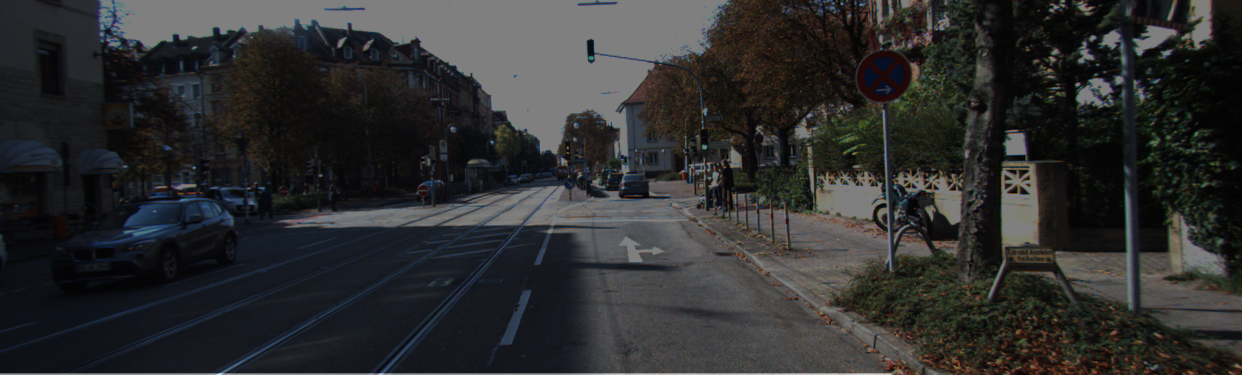

In [13]:
#U-Net 결과 시각화
i = 1   

get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

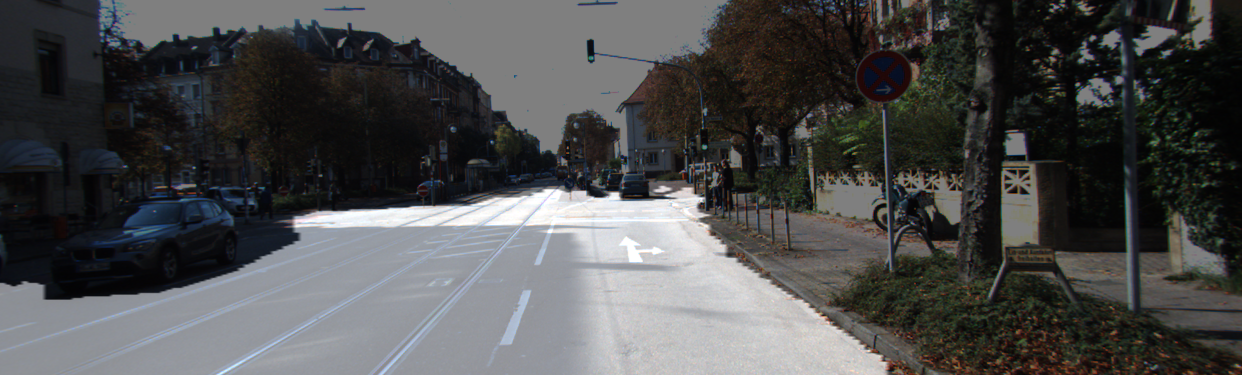

In [14]:
#U-Net++ 결과 시각화
i = 1
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 3.2 IoU 비교

In [15]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [16]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #threshold(0.5)를 변경하면 도로인식 결과범위가 달라짐.
    prediction = output/255   #도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   #도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   #라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [17]:
i = 1  
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.012660


0.012660218605016907

In [18]:
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.925147


0.9251473782190506

---

## - 프로젝트 정리

1. U-Net ++ 모델   
Resnet 구현도 많이 힘들었기에 이번 역시 모델 구현이 어려워서 [링크](https://github.com/kec0130/AIFFEL-project/blob/main/goingdeeper/G8_semantic_segmentation_pjt.ipynb)를 참고하여 모델을 구현했다.   
무작정 붙잡고 시간 흘려보내는 것 보다 타인의 코드를 보며 공부하는 것도 큰 도움이 된다는 것을 느꼈다.   
   
   
2. 결과 시각화 비교   
![result](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd10/results/result_plt.JPG?raw=true)   

두 결과를 놓고 비교하면, 확실히 명암의 구분이 뚜렷해진 것을 볼 수 있었다. U-Net으로만 결과를 시각화 했을 때 도로가 구별이 된 것인지 인지할 수 없었지만 U-Net++의 결과를 시각화하니 도로 영역이 밝아진 것을 보아 제대로 구별이 된 것을 알 수 있었다.      


3. IoU 비교
U-Net의 IoU는 0.012660로 굉장히 낮게 나왔으며 U-Net++의 IoU는 0.925147로 높게 나와 U-Net++의 성능이 훨씬 좋다는 것을 알 수 있다.   